In [1]:
!pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf

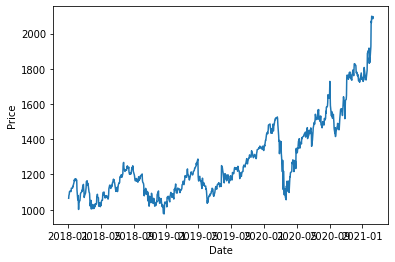

In [24]:
# Download stock data and plot the history diagram

import yfinance as yf
from datetime import datetime

stockName = "GOOG"
stkTicker = yf.Ticker(stockName)
dfHist = stkTicker.history(start="2018-01-01", end=datetime.today().strftime('%Y-%m-%d'), interval = "1d")
#np.set_printoptions(threshold=np.inf)
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(dfHist['Close'])

In [25]:
dfHist['Target'] = np.where(dfHist['Close'].shift(-1) > dfHist['Close'], 1, 0)
dfHist = dfHist[1:]

In [26]:
dfHist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Target
Date,,,,,,,,
2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1430200,0,0,1
2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1004600,0,0,1
2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1279100,0,0,1
2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1047600,0,0,0
2018-01-09,1109.400024,1110.569946,1101.230957,1106.260010,902500,0,0,0
...,...,...,...,...,...,...,...,...
2021-02-04,2068.889893,2078.550049,2042.589966,2062.370117,1852300,0,0,1
2021-02-05,2070.000000,2102.510010,2059.330078,2098.000000,1533900,0,0,0
2021-02-08,2105.909912,2123.547119,2072.000000,2092.909912,1241900,0,0,0


In [27]:
# Get train set and test set

from sklearn.model_selection import train_test_split 

dataset = dfHist['Close'].values
target = dfHist['Target'].values
sizeTrain = int(dataset.shape[0]*0.63)
sizeTest = dataset.shape[0] - sizeTrain
print("The length of data is:",dataset.shape[0], \
      "\nThe length of Training is:", sizeTrain, \
      "\nThe length of Testing is:", sizeTest)
xTrain = dataset[ : sizeTrain]
xTest = dataset[sizeTrain : ]
yTrain = target[ : sizeTrain]
yTest = target[sizeTrain :]

The length of data is: 782 
The length of Training is: 492 
The length of Testing is: 290


In [28]:
from scipy.ndimage.interpolation import shift

def predOnError(data, size):
  data = data.flatten()
  out=data.copy()
  for i in range(data.size - size + 1):
    nData = data[i:i+size]
    pattern = shift(nData,-1)
    pattern[size-1]=1
    pattern_1 = pattern.copy() 
    pattern[size-1]=0
    pattern_0 = pattern .copy()
    cov_1 = abs(np.cov(nData, pattern_1)[0,1])
    cov_0 = abs(np.cov(nData, pattern_0)[0,1])
    if cov_1 < cov_0:
      out[i:i+size] = 1
    else:
      out[i:i+size] = 0
  return out

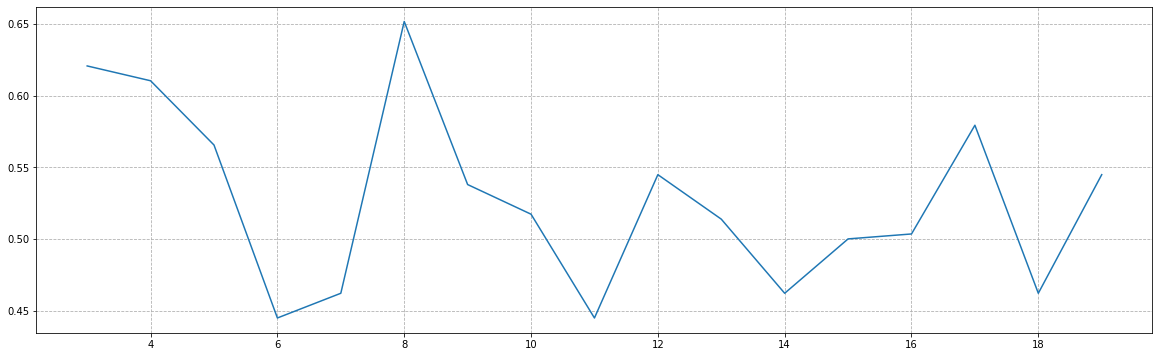

In [29]:
res = []
n = []
for i in range (3,20):
  out = predOnError(yTest,i)
  cmp = np.where(out == yTest, 1, 0)
  res.append(cmp.mean())
  n.append(i)

plt.figure(figsize=(20, 6))
plt.grid(ls='--')
plt.plot(n,res)

In [31]:
pred = predOnError(yTest,4)
cmp = np.where(pred == yTest, 1, 0)
cmp.mean()

0.6103448275862069

In [32]:
def SumRes(pred,close,lever,isPrint):
    pred = pred.flatten()
    close = close.flatten()
    j = 0
    gain = 1
    for i in range(pred.size-1):
        if pred[i] == 1:
          j=j+1
          tmp = (close[i] + lever * (close[i+1]-close[i])) / close[i]
          if tmp <0:
            gain = 0
            tmp = 0
          gain = gain * tmp
          if isPrint ==0:
            print(i, "\tCurrClose:%.02f" %close[i], \
                     "  \tActualGain%+.02f" %(close[i+1]/close[0]), \
                     "  \tPredictedGain%+.02f" %gain)
    if isPrint ==0 or isPrint ==1:
        print("\n\n\nFinal gain comparasion:\t",gain,"rather than Long-Term-Gain",close[pred.size-1]/close[0],", Trading times",j)
    return gain

In [33]:
def dispLever(pred,close):
    disp  = []
    lever = []
    l = float(0)
    while l<=10:
        disp.append(SumRes(pred,close,l,2))
        lever.append(l)
        l=l+0.1
    disp = np.array(disp).reshape(-1,1)
    lever = np.array(lever).reshape(-1,1)
    plt.figure(figsize=(20, 6))
    plt.xticks(np.linspace(0, 10, 21))
    plt.grid(ls='--')
    plt.plot(lever, disp)

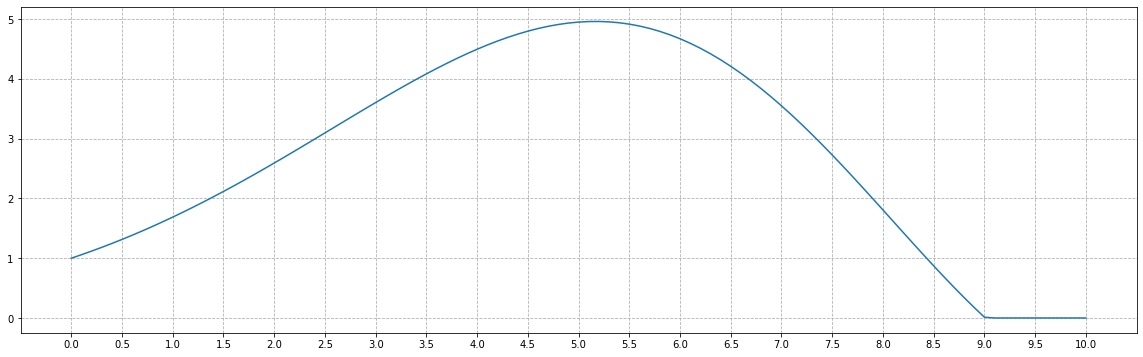

In [34]:
dispLever(pred,xTest)

In [35]:
SumRes(pred,xTest,5,1)




Final gain comparasion:	 4.950122253102406 rather than Long-Term-Gain 1.546268884204086 , Trading times 159


4.950122253102406